## Threshold Selection (Based on NN2 Model)
After the model comparison, we chose NN2 model as our base model to generate predicted default probabilities for each client and conduct further threshold selection.

In [ ]:
# Here we train the final NN2 model again
X = tree_raw.drop('loan_status',axis=1)
scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
y = tree_raw['loan_status']

oversampler = RandomOverSampler(sampling_strategy='minority')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
X_train, y_train = oversampler.fit_resample(X_train, y_train)

X_train = np.array(X_train)
y_train = np.array(y_train)

# Final NN2 Model
model_nn2 = Sequential()
model_nn2.add(Dense(42, activation='tanh', kernel_regularizer=regularizers.l2(0.001), bias_regularizer=regularizers.l2(0.001))) # Input layer
model_nn2.add(Dropout(0))
model_nn2.add(Dense(10, activation='tanh', kernel_regularizer=regularizers.l2(0.001), bias_regularizer=regularizers.l2(0.001))) # hidden layer 1
model_nn2.add(Dropout(0.2))
model_nn2.add(Dense(11, activation='tanh', kernel_regularizer=regularizers.l2(0.001), bias_regularizer=regularizers.l2(0.001))) # hidden layer 2
model_nn2.add(Dropout(0))
model_nn2.add(Dense(1, activation='sigmoid'))                                                                                   # Output layer
model_nn2.compile(loss=BinaryCrossentropy(from_logits=False), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  metrics=[f1, tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
model_nn2.fit(X_train, y_train, epochs=100)

### Import Non-scaled features again to do further calculations
Since the dataset was already standardised, the features are scaled and are not the exact values they should be so we need to use the unscaled values to conduct further research on threshold selection.

In [299]:
# Use the unscaled values to conduct further research
X_non_scaled = continue_tree_raw.drop('loan_status',axis=1)
X_train_ns,X_test_ns,y_train_ns,y_test_ns = train_test_split(X_non_scaled, y, test_size=0.2, random_state=random_state)
total_payments = X_test_ns['total_pymnt']

# Generate the predicted default probabilities for each client in test dataset
predicted_prob = model_nn2.predict(X_test)
X_test_ns = pd.DataFrame(X_test_ns)
predicted_prob = pd.DataFrame(predicted_prob, columns=['Output'])
total_payments = pd.DataFrame(total_payments)

# Here we produce the dataframe "X_test_return_cal" containing all needed data in 1. Average Return Calculation
X_select = X_test_ns.loc[:,['loan_amnt','term']]
X_test_return_cal = pd.concat([y_test.reset_index(drop=True),
                               X_select.reset_index(drop=True),
                               total_payments.reset_index(drop=True),
                               predicted_prob.reset_index(drop=True)], axis=1)

# Resume the true value of the categorical variable "term"
X_test_return_cal['term'].replace(0, 3, inplace=True)
X_test_return_cal['term'].replace(1, 5, inplace=True)

# Calculate the annual return for each loan and create a new column
X_test_return_cal['annualized_return'] = ((X_test_return_cal['total_pymnt'] / X_test_return_cal['loan_amnt']) **
                                          (1/X_test_return_cal['term']) - 1) * 100

### 1. Average Annualized Return VS Predicted Default Rate generated (Without considering the cost of capital)

In [300]:
list_1 = [x/1000 for x in range(0, 1000, 1)]
return_output = []

# Based on the Predicted Default Rate, we sort clients into 100 groups, and then we calculate the average return for each group
for i in list_1:
    cond1 = X_test_return_cal['Output']> i
    cond2 = X_test_return_cal['Output'] < i + 0.01
    return_avg = X_test_return_cal.loc[cond1 & cond2, 'annualized_return'].mean()
    return_output.append(return_avg)

# Then we map each group's Predicted Default Rate with its annual return into return_output_1
return_output_1 = [float(i) for i in return_output]
return_output_1 = pd.DataFrame(return_output_1, index= list_1, columns = ['Average Returns on loans'])

After digging into the data, we know that we can reach the highest total profit when we choose the predicted default probability of **31.2%** as the threshold.
(Accepting all clients with default probability lower than **31.2%**)

In [301]:
return_above_zero = return_output_1.copy()
return_above_zero[return_above_zero['Average Returns on loans'] < 0] = 0
return_below_zero = return_output_1.copy()
return_below_zero[return_below_zero['Average Returns on loans'] > 0] = 0

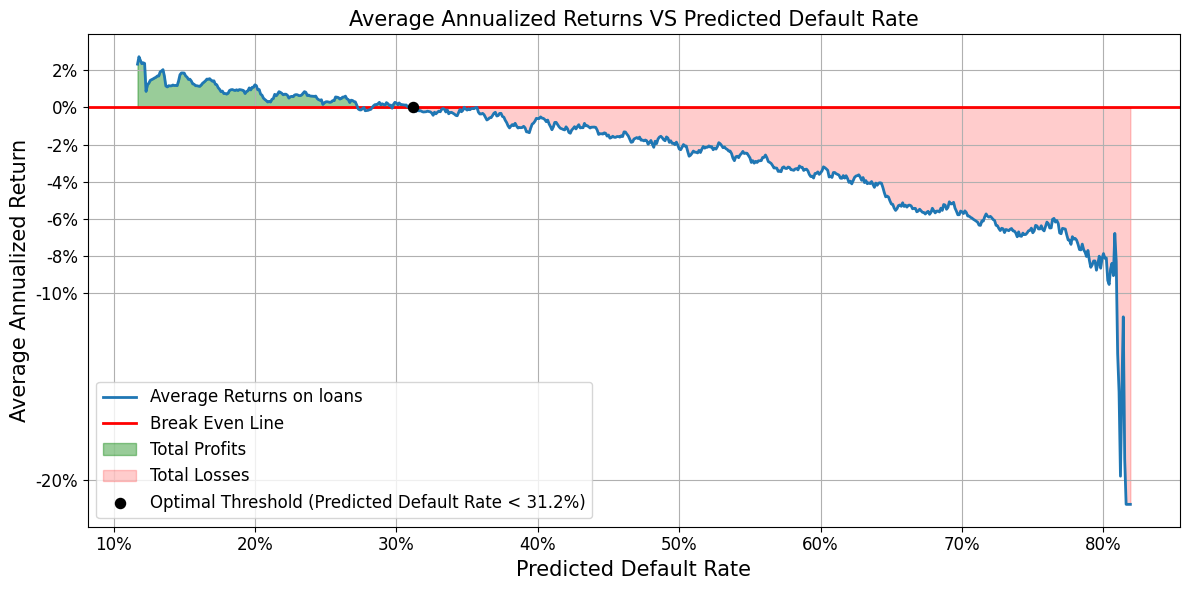

In [329]:
return_output_1.plot(label = 'Average Returns on loans', figsize=(12,6), grid=True, linewidth=2, fontsize=12, zorder=3)
plt.axhline(y=0, color='r', linestyle='-',linewidth=2,label='Break Even Line', zorder=2)
plt.fill_between(return_output_1.index, 0, return_above_zero['Average Returns on loans'], color='green', alpha=0.4, label='Total Profits', zorder=1)
plt.fill_between(return_output_1.index, 0, return_below_zero['Average Returns on loans'], color='red', alpha=0.2, label='Total Losses', zorder=1)
plt.xticks([x/10 for x in range(0, 9, 1)], ['10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%'])
plt.yticks([-40, -30, -20, -10, -8, -6, -4, -2, 0 , 2, 4], ['-40%','-30%','-20%','-10%','-8%','-6%','-4%','-2%','0%','2%','4%'])
plt.scatter(0.312, 0, marker = '.', s = 210, c = 'black', label='Optimal Threshold (Predicted Default Rate < 31.2%)', zorder=4)
plt.title('Average Annualized Returns VS Predicted Default Rate', fontsize=15)
plt.xlabel('Predicted Default Rate', fontsize=15)
plt.ylabel('Average Annualized Return', fontsize=15)
plt.legend(fontsize=12, loc='lower left')
plt.tight_layout()
plt.show()

So far, we have not taken into account the discount rate (cost of capital) so the above analysis would be a bit too optimistic. Thus, in the following section, we take into account the discount rate to calculate the NPV of each loan.

### 2. Total Net Present Value VS Predicted Default Probability (With considering the cost of capital)

In [ ]:
# Here we produce the dataframe "X_test_return_cal" containing all needed data in 2. NPV Calculation
X_select_2 = X_test_ns.loc[:,['int_rate', 'term', 'total_pymnt', 'loan_amnt', 'sub_grade', 'installment']]
X_test_npv_cal = pd.concat([y_test.reset_index(drop=True),
                            X_select_2.reset_index(drop=True),
                            predicted_prob.reset_index(drop=True)], axis=1)
# Resume the true value of the categorical variable "term"
X_test_npv_cal['term'].replace(0, 3, inplace=True)
X_test_npv_cal['term'].replace(1, 5, inplace=True)

To calculate the actual NPV of each loan brought to us, we first need to divide and classify the total payment of each loan into each year's payments.

In [306]:
# We assume that defaulters' outstanding debts occurred in the last several periods of payment of their loans.
# For example, if one defaulter's loan amount is 15,000, his total payment is 10,000, and his required annual payment is 5,000
# Then we deem he successfully paid the first 2 years' instalments and defaulted in the 3rd year of his loan.

# Based on this assumption, we can calculate the net present value each loan brought to us

# We calculate the annual payment by multiply the monthly instalment by 12
X_test_npv_cal['annual_pymnt'] = 12 * X_test_npv_cal['installment']

# The actual 1st-year payment of each client can be:
# (1) annual_pymnt if total_pymnt > annual_pymnt,
# (2) total_pymnt under other conditions
X_test_npv_cal['1st_y_pymnt'] = X_test_npv_cal.apply(lambda x: x['annual_pymnt'] if x['total_pymnt'] > x['annual_pymnt'] \
                                                         else x['total_pymnt'], axis=1)

# The actual 2nd-year payment of each client can be:
# (1) annual_pymnt if total_pymnt > 2*annual_pymnt
# (2) total_pymnt - annual_pymnt if annual_pymnt < total_pymnt < 2*annual_pymnt
# (3) 0 if the total_pymnt <= annual_pymnt
X_test_npv_cal['2nd_y_pymnt'] = X_test_npv_cal.apply(lambda x: x['annual_pymnt'] if x['total_pymnt'] > 2*x['annual_pymnt'] \
                                                         else ((x['total_pymnt'] - x['annual_pymnt'])
                                                               if x['total_pymnt'] > x['annual_pymnt'] else 0), axis=1)

# The actual 3rd-year payment of each client can be:
# (1) 0 if the total_pymnt < 2*annual_pymnt
# (2) total_pymnt - 2*annual_pymnt if 2*annual_pymnt < total_pymnt < 3*annual_pymnt or its repayment term == 3
# (3) annual_pymnt under other conditions
X_test_npv_cal['3rd_y_pymnt'] = X_test_npv_cal.apply(lambda x: 0 if x['total_pymnt'] < 2*x['annual_pymnt'] \
                                                         else (x['total_pymnt'] - 2*x['annual_pymnt']
                                                           if x['total_pymnt'] < 3*x['annual_pymnt'] or x['term'] == 3
                                                           else x['annual_pymnt']), axis=1)

# The actual 4th-year payment of each client can be:
# (1) 0 if the 3rd_y_pymnt < annual_pymnt or its repayment term == 3
# (2) total_pymnt - 3*annual_pymnt if 3*annual_pymnt < total_pymnt < 4*annual_pymnt
# (3) annual_pymnt under other conditions
X_test_npv_cal['4th_y_pymnt'] = X_test_npv_cal.apply(lambda x: 0 if (x['term'] == 3 or x['3rd_y_pymnt'] < x['annual_pymnt']) \
                                                         else ((x['total_pymnt'] - 3*x['annual_pymnt'])
                                                               if (x['total_pymnt'] - 3 * x['annual_pymnt']) > 0
                                                                  > (x['total_pymnt'] - 4 * x['annual_pymnt'])
                                                               else x['annual_pymnt']), axis=1)

# The actual 5th-year payment of each client can be:
# (1) 0 if the 4rd_y_pymnt < annual_pymnt or its repayment term == 3
# (2) total_pymnt - 4*annual_pymnt under other conditions
X_test_npv_cal['5th_y_pymnt'] = X_test_npv_cal.apply(lambda x: 0 if (x['term'] == 3 or x['4th_y_pymnt'] < x['annual_pymnt']) \
                                                         else x['total_pymnt'] - 4*x['annual_pymnt'], axis=1)

# Average cost of capital from April 2016 to Sep. 2020 is 1.8% in the USA. (Based on Fred Economic data)
# After the above division and classification, we now can calculate the Net Present Value for each loan.
# The Present Value of a certain year's payment is its actual amount divided by (1 + 1.8%)^year
# NPV = Total Present Value of each year's payment - loan amount
X_test_npv_cal['npv'] = (X_test_npv_cal['1st_y_pymnt']/1.018 +
                         X_test_npv_cal['2nd_y_pymnt']/1.018**2 +
                         X_test_npv_cal['3rd_y_pymnt']/1.018**3 +
                         X_test_npv_cal['4th_y_pymnt']/1.018**4 +
                         X_test_npv_cal['5th_y_pymnt']/1.018**5) - X_test_npv_cal['loan_amnt']

In [311]:
list_2 = [x/1000 for x in range(0, 1000, 1)]
npv_output = []
# Based on the Predicted Default Rate, we sort clients into 100 groups, and then we calculate the sum of NPV for each group
for i in list_2:
    cond1 = X_test_npv_cal['Output'] > i
    cond2 = X_test_npv_cal['Output'] < i + 0.01
    total_npv = X_test_npv_cal.loc[cond1 & cond2, 'npv'].sum()
    npv_output.append(total_npv)

npv_output = [i for i in npv_output]
npv_output = pd.DataFrame(npv_output, index=list_1, columns=['Total NPV on Loans'])
npv_output = npv_output.iloc[117:820,:]

After digging into the data, we know that we can reach the highest NPV when we choose the predicted default probability of **24.7%** as the threshold.
(Accepting all clients with default probability lower than **24.7%**)

In [313]:
npv_above_zero = npv_output.copy()
npv_above_zero[npv_above_zero['Total NPV on Loans'] < 0] = 0
npv_below_zero = npv_output.copy()
npv_below_zero[npv_below_zero['Total NPV on Loans'] > 0] = 0

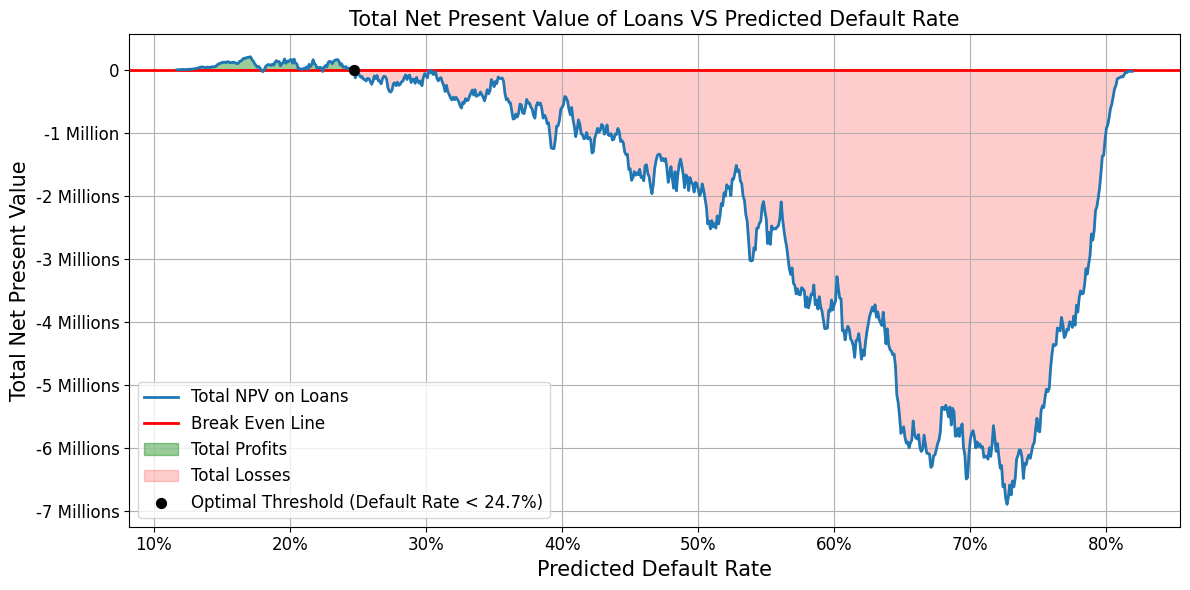

In [330]:
npv_output.plot(label = 'Total Net Profit on loans', figsize=(12,6), grid=True, linewidth=2, fontsize=12, zorder=3)
plt.axhline(y=0, color='r', linestyle='-',linewidth=2,label='Break Even Line', zorder=2)
plt.fill_between(npv_output.index, 0, npv_above_zero['Total NPV on Loans'], color='green', alpha=0.4, label='Total Profits', zorder=1)
plt.fill_between(npv_output.index, 0, npv_below_zero['Total NPV on Loans'], color='red', alpha=0.2, label='Total Losses', zorder=1)
plt.xticks([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8], ['10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%'])
plt.yticks([-7000000, -6000000, -5000000, -4000000, -3000000, -2000000, -1000000, 0, 1000000], ['-7 Millions', '-6 Millions', '-5 Millions','-4 Millions', '-3 Millions', '-2 Millions', '-1 Million', '0', '1 Million'])
plt.scatter(0.247, 0, marker = '.', s = 200, c = 'black', label='Optimal Threshold (Default Rate < 24.7%)', zorder=4)
plt.title('Total Net Present Value of Loans VS Predicted Default Rate', fontsize=15)
plt.xlabel('Predicted Default Rate', fontsize=15)
plt.ylabel('Total Net Present Value', fontsize=15)
plt.legend(fontsize=12, loc='lower left')
plt.tight_layout()
plt.show()

In [ ]:
target_clients = X_test_npv_cal[X_test_npv_cal['Output'] < 0.247]
total_profit_247 = (target_clients['total_pymnt'] - target_clients['loan_amnt']).sum()
total_npv_247 = target_clients['npv'].sum()

print('Total NPV If We Choose Customers With Default Rate Below 24.7%: $ {:.0f} US Dollars'.format(total_npv_247))

The total NPV If We Accept all Customers With A Default Rate Lower Than 24.7% is: $ 964,049 US Dollars

### 3. Optimal Interest Rate Selection for Our Target Clients (With Predicted Default Probability < 24.7%)
After deciding the threshold, we can further decide, within these target clients, what level of interest rate is optimal to earn the highest NPV.

In [319]:
# Here, we divide all clients into 2 groups, one with a default rate higher than or equal to 24.7%, and one with a default rate lower than 24.7%.
# Target Clients
X_test_below_247 = X_test_npv_cal[X_test_npv_cal['Output'] < 0.247]
# Non-target Clients
X_test_above_247 = X_test_npv_cal[X_test_npv_cal['Output'] >= 0.247]

In [320]:
int_output_1 = []
int_output_2 = []
list_3 = [x/1000 for x in range(0, 1000, 1)]
# Based on the Interest Rate, we sort clients into 100 groups, and then we calculate the average NPV for each group
for i in list_3:
    # Here, we calculate the average NPV under different default rate for clients with a default rate lower than 24.7%.
    cond1 = X_test_below_247['int_rate']/100 >= i
    cond2 = X_test_below_247['int_rate']/100 < i + 0.01
    npv_sum_over_int_1 = X_test_below_247.loc[cond1 & cond2, 'npv'].mean()
    int_output_1.append(npv_sum_over_int_1)
    # Here, we calculate the average NPV under different default rate for clients with a default rate higher than or equal to 24.7%.
    cond3 = X_test_above_247['int_rate']/100 >= i
    cond4 = X_test_above_247['int_rate']/100 < i + 0.01
    npv_sum_over_int_2 = X_test_above_247.loc[cond3 & cond4, 'npv'].mean()
    int_output_2.append(npv_sum_over_int_2)
    
# Here we merge the result into a dataframe for the plotting purposes
int_output_1 = [i for i in int_output_1]
int_output_1 = pd.DataFrame(int_output_1, index=list_3, columns = ['Avg. NPV on Loans (Target Clients)'])
int_output_2 = [i for i in int_output_2]
int_output_2 = pd.DataFrame(int_output_2, index=list_3, columns = ['Avg. NPV on Loans (Non-target Clients)'])
int_output = pd.concat([int_output_1, int_output_2], axis = 1)
int_output = int_output.iloc[49:290,:]

Among the 14,678 clients, we calculated the average NPV generated by their loans under different interest rates. As we can find in the plot, when setting **12.5%** as the interest rate, we can obtain the highest average NPV, **$534**.

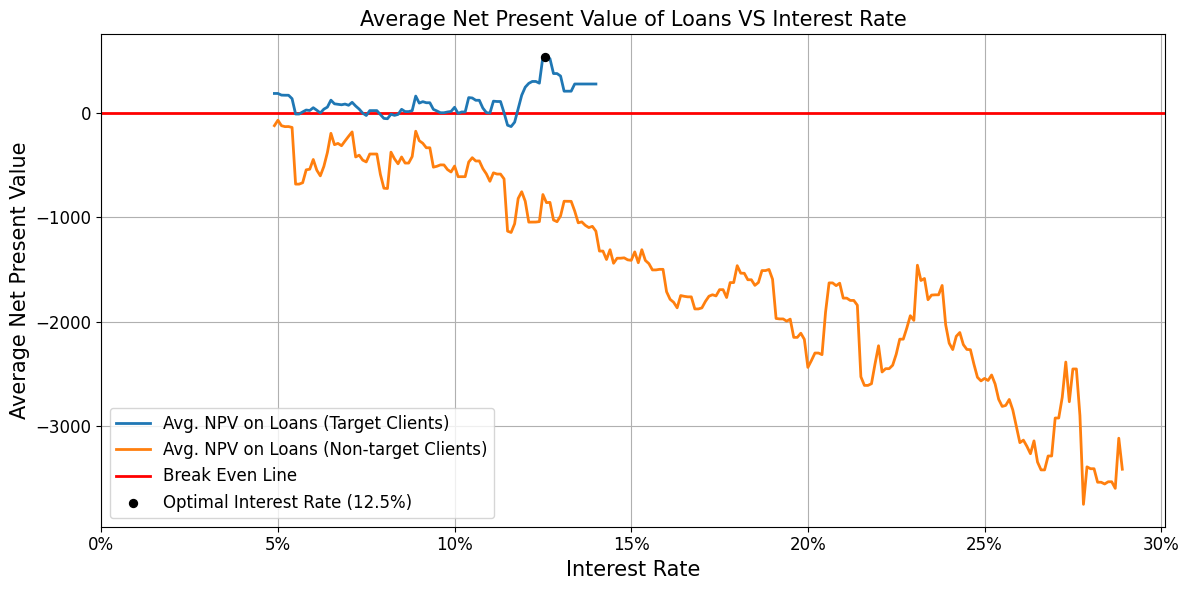

In [331]:
int_output.plot(figsize=(12,6), grid=True, linewidth=2, fontsize=12, zorder=3)
plt.axhline(y=0, color='r', linestyle='-',linewidth=2,label='Break Even Line', zorder=2)
plt.scatter(0.1255, 533.777109, marker = '.', s = 130, c = 'black', label='Optimal Interest Rate (12.5%)', zorder=4)
plt.title('Average Net Present Value of Loans VS Interest Rate', fontsize=15)
plt.xticks([0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3], ['0%', '5%', '10%','15%', '20%', '25%', '30%'])
plt.xlabel('Interest Rate', fontsize=15)
plt.ylabel('Average Net Present Value', fontsize=15)
plt.legend(fontsize=12, loc='lower left')
plt.tight_layout()
plt.show()

### * For Our Own Reference

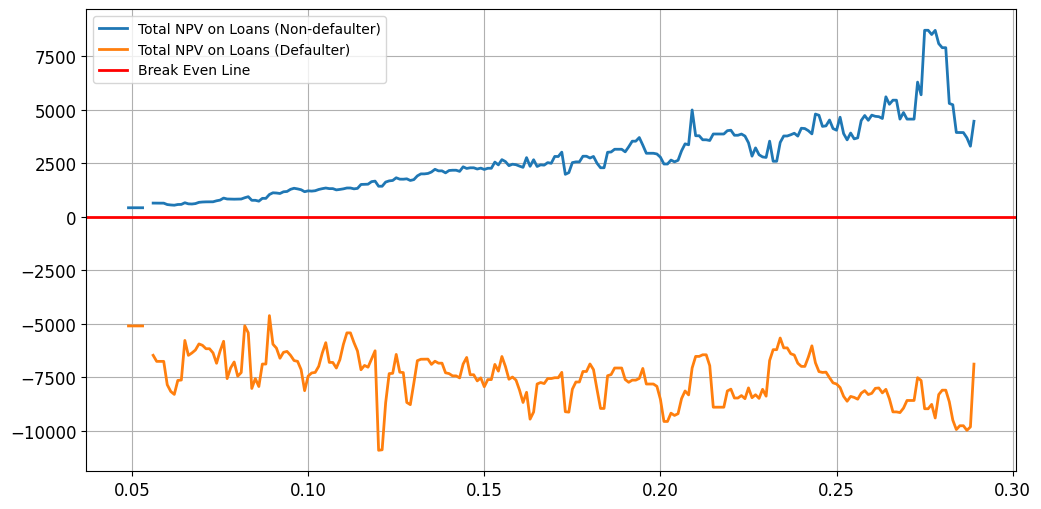

In [388]:
X_test_non_defaulter = X_test_npv_cal[X_test_npv_cal['loan_status'] == 0]
X_test_defaulter = X_test_npv_cal[X_test_npv_cal['loan_status'] == 1]

int_output_3 = []
int_output_4 = []
list_3 = [x/1000 for x in range(0, 1000, 1)]
for i in list_3:
    npv_sum_over_int_3 = X_test_non_defaulter.loc[(X_test_non_defaulter['int_rate']/100 >= i) & (X_test_non_defaulter['int_rate']/100 < i + 0.005), 'npv'].mean()
    int_output_3.append(npv_sum_over_int_3)
    npv_sum_over_int_4 = X_test_defaulter.loc[(X_test_defaulter['int_rate']/100 >= i) & (X_test_defaulter['int_rate']/100 < i + 0.005), 'npv'].mean()
    int_output_4.append(npv_sum_over_int_4)

int_output_3 = [i for i in int_output_3]
int_output_3 = pd.DataFrame(int_output_3, index=list_3, columns = ['Total NPV on Loans (Non-defaulter)'])
int_output_4 = [i for i in int_output_4]
int_output_4 = pd.DataFrame(int_output_4, index=list_3, columns = ['Total NPV on Loans (Defaulter)'])
int_output_1 = pd.concat([int_output_3, int_output_4], axis = 1)
int_output_1 = int_output_1.iloc[44:290,:]

int_output_1.plot(figsize=(12,6), grid=True, linewidth=2, fontsize=12, zorder=3)
plt.axhline(y=0, color='r', linestyle='-',linewidth=2,label='Break Even Line', zorder=2)
plt.legend()
plt.show()